In [1]:
import sys, os, csv
import numpy as np
import getStockData

def main():
    
    # get data
    dateSelected, stockPrice = getStockData.getData()
    
    # get time for baseline estimation  
    # [0,10],[0,11],...,[0,len(dateSelected)]
    Time = xrange(10,len(dateSelected)+1) 
    Date = [dateSelected[i-2][0] for i in Time]
    
    estimateReturn = np.zeros(len(Time)) 
    
    # total asset
    M = np.zeros(len(Time)+1) 
    M[0] = 28348.5754100817
    
    # parameters for transaction cost
    c = np.zeros(len(stockPrice[-1])+1) + 0.001
    
    # calculate return including transaction cost
    for i in xrange(len(Time)):
        # estimateReturn[i] is return for [Time[i]-1, Time[i]]
        estimateReturn[i], eigenportfolio = calculateReturn(stockPrice[0:Time[i]]) 
        if i == 0:
            estimateReturn[i] -= 0.002
            M[i+1] = M[i]*(1 + estimateReturn[i])
            beforePt = eigenportfolio
        else:
            flag = 0
            for j in xrange(len(stockPrice[-1])):
                tmp = eigenportfolio[j]-beforePt[j]*M[i-1]/M[i]*stockPrice[Time[i]-1][j]/stockPrice[Time[i]-2][j]
                estimateReturn[i] = estimateReturn[i] - c[j+1] * np.abs(tmp)
                if tmp != 0:
                    flag = 1
            if flag:
                estimateReturn[i] = estimateReturn[i] - c[0]
            M[i+1] = M[i]*(1 + estimateReturn[i])
            beforePt = eigenportfolio
    
    return estimateReturn, Date, M
    

# stockReturn: return for each time period
def calculateReturn(stockPrice):
    
    """
    flag = 0
    for i in xrange(len(stPrice[-2])):
        if stPrice[-2][i] > stPrice[-3][i]:
            flag = 1
            break
    if flag == 0: # if stock prices all decrease in the previous time period, do not invest at current step
        return None,0,np.append([1],np.zeros(len(stPrice[-2])))
    """
    
    mu = xrange(10)
    stockReturn = getPeriodReturn(stockPrice)
    
    # choose mu_max and portReturn_max based on maximizing return for last second period
    mu_max = 0
    portReturn_max = -100000
    for mui in mu:
        portReturn, eigenportfolio = baselineReturn(stockReturn[:-1], mui)
        if portReturn > portReturn_max:
            portReturn_max = portReturn
            mu_max = mui
    return baselineReturn(stockReturn[:-1], mu_max)


def getPeriodReturn(stockPrice):
    stockReturn = np.empty((len(stockPrice)-1,len(stockPrice[0])))
    for i in xrange(len(stockPrice)-1):
        stockReturn[i] = (np.array(stockPrice[i+1]) - np.array(stockPrice[i]))/np.array(stockPrice[i])
    return stockReturn

    
def baselineReturn(stockReturn, mu):
    cov = getCovarianceMatrix(stockReturn[:-1], mu)
    eigenportfolio = getLargestEigenvector(cov)
    portReturn = np.dot(eigenportfolio, stockReturn[-1])
    return portReturn, eigenportfolio
    

# exponential weighted average mean and covariance matrix
# stocknum: num of stockPrice
# mu: hyperparameter for weighted exponential mean 
# T: number of time period
def getCovarianceMatrix(stockReturn, mu):
    stocknum = len(stockReturn[0])
    returnSum = np.zeros(stocknum)
    T = len(stockReturn)
    denumerator = 0
    
    # calculate weighted exponential mean
    for i in xrange(T):
        returnSum = returnSum + stockReturn[i] * np.exp(-mu * (T-i))
        denumerator += np.exp(-mu * (T-i))
    meanReturn = returnSum / denumerator

    # calculate weighted exponential covariance matrix
    cov = np.zeros((stocknum, stocknum))
    for i in xrange(T):
        normalizedReturn = (stockReturn[i] - meanReturn)
        cov = cov + \
        np.dot(np.transpose(normalizedReturn),normalizedReturn) * np.exp(-mu * (T-i))
    
    cov  = cov / denumerator
    return cov
        
    
# calculate largest eval-eigenvector 
def getLargestEigenvector(cov):
    D, S = np.linalg.eigh(cov)
    eigenportfolio = S[:,-1] / np.sum(S[:,-1]) 
    return eigenportfolio

if __name__=='__main__':
    estimateReturn, Date, M = main()


extracting csv data from data/sp10/
['AAPL.csv', 'ADSK.csv', 'EBAY.csv', 'FB.csv', 'GOOGL.csv', 'INTC.csv', 'INTU.csv', 'NFLX.csv', 'ORCL.csv', 'SYMC.csv']


In [3]:
print estimateReturn
print Date
print M
print M[-1]/M[0]

[-0.02421547  0.05222869 -0.09046368 -0.00382946  0.11988154  0.04195779
 -0.05768819 -0.06041435  0.01016644  0.05631207 -0.03990764  0.02985751
 -0.0025518   0.07447172  0.04810247  0.01408586  0.01387937 -0.0200319
  0.02000885  0.07848633  0.04372547  0.00936046  0.03902748  0.05305378
 -0.03629787  0.06789998  0.01128169]
['2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', '2017-07-03', '2017-08-01', '2017-09-01']
[ 28348.57541008  27662.10126418  29106.85655806  26473.74308243
  26372.36304367  29533.92257154  30773.1006659   28997.8561283
  27245.96950868  27522.96411242  29072.83927853  27912.61081875
  28746.01182217  28672.65764402  30807.95975199  32289.89861981
  32744.72949428  33199.20577893 

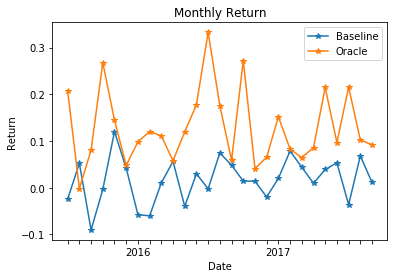

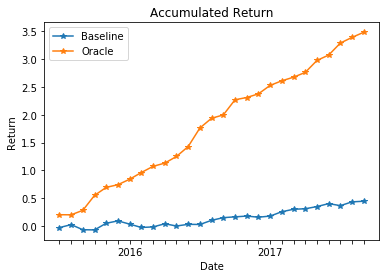

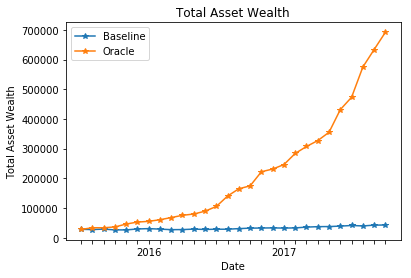

In [4]:
Re = estimateReturn
Date = ['' for i in xrange(len(Re))]
Date[6] = '2016'
Date[18] = '2017'
import matplotlib.pyplot as plt
x = xrange(len(Re))
plt.plot(x,Re,'*-')
Re2 =  [0.033005935128213405, 0.06892715856320995, 0.2755535307416944, 0.17568743261034575, 0.0413012437652522, 0.33589530173824533, 0.11146847794454445, 0.0911982624167817, 0.20668713994921434, -0.0020024884553326724, 0.08040770333048929, 0.26783143638994944, 0.1443769205292472, 0.04761262361168394, 0.09822322970747711, 0.12025556695756462, 0.11097578112827389, 0.057630141518551455, 0.11966053342990979, 0.17771331115045197, 0.3328915604441246, 0.17513337436843268, 0.058896823913601314, 0.27230331741348024, 0.04065536746902061, 0.06540685701240898, 0.15196789334287716, 0.08248901006565279, 0.0644755218050552, 0.08583373167712899, 0.2146539211946878, 0.09651420187037969, 0.21522156984578386, 0.10229596211164588, 0.09188782343847067]
Re2 = Re2[len(Re2)-len(Re):]
plt.plot(x,Re2,'*-')
plt.xticks(x, Date)
plt.title('Monthly Return')
plt.legend(['Baseline','Oracle'])
plt.xlabel('Date')
plt.ylabel('Return')
plt.savefig('Monthly_Re')
#plt.margins(0.2)
#plt.subplots_adjust(bottom=0.15)
plt.show()

sumRe = [Re[0],]
sumRe2 = [Re2[0],]
for i in xrange(1,len(Re)):
    sumRe.append(sumRe[-1]+Re[i])
    sumRe2.append(sumRe2[-1]+Re2[i])
plt.plot(x,sumRe,'*-')
plt.plot(x,sumRe2,'*-')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(x, Date)
plt.title('Accumulated Return')
plt.legend(['Baseline','Oracle'])
plt.savefig('Accumulated_Re')
plt.show()

M2 =  [10000, 10330.059351282134, 11042.080990155328, 14084.765393728374, 16559.281664671558, 17243.200593281632, 23035.110659495058, 25602.799383993126, 27937.730200818751, 33712.099752698763, 33644.591662138962, 36349.876007183688, 46085.515510784258, 52739.200321234144, 55250.252015710263, 60677.110210845378, 67973.87050059723, 75517.323875713148, 79869.397937772781, 89426.612699732403, 105318.9121475709, 140378.68915665342, 164963.68267807545, 174679.51964890529, 222245.33233349543, 231280.7979877883, 246408.14807149139, 283854.2752364357, 307269.13340359263, 327080.47111437639, 355155.00850883668, 431390.42371719121, 473025.72615678085, 574831.06551768503, 633633.96241647925, 691857.20807962317]
M2 = M2[len(M2)-len(Re)-1:]
x = xrange(len(M2))
plt.plot(x,M,'*-')
plt.plot(x,M2,'*-')
plt.xlabel('Date')
plt.ylabel('Total Asset Wealth')
plt.xticks(x, Date)
plt.legend(['Baseline','Oracle'])
plt.title('Total Asset Wealth')
plt.savefig('Asset')
plt.show()

In [14]:
b = np.vstack([a,[0,0,0]])
cov = np.insert(b,0,0,axis=0)
cov = np.insert(cov,0,0,axis=1)

In [33]:
print np.shape(a)

(1, 3)
